In [3]:
from __future__ import print_function
import imageio, keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
from keras import backend as K

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"
GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
%matplotlib inline

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [5]:
from keras.datasets import mnist

num_classes=10

img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# Copy data to 3 channels and resample to get 56x56 images
# VGG needs atleast 48x48, so resample
# Center and resample diffraction array to desired pixel spacing
from scipy.ndimage.interpolation import zoom

def resample(diff3D, Nx, Ny): 
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D


from tqdm import tqdm
def copy3channels(input_data):
    dims = input_data.shape
    dataset3 = np.zeros((dims[0],28,28,3),float)
    for i in tqdm(range(dims[0])):
        dataset3[i,:,:,0], dataset3[i,:,:,1], dataset3[i,:,:,2] = input_data[i,:,:,0], input_data[i,:,:,0], input_data[i,:,:,0]
    data=[]
    for i in tqdm(range(dims[0])):
        tmp=resample(dataset3[i,:,:,:],56,56)
        data.append(tmp)
    return np.array(data)

In [7]:
x_train_prepro = copy3channels(x_train)
x_test_prepro = copy3channels(x_test)

100%|██████████| 10000/10000 [00:08<00:00, 1249.94it/s]


In [11]:
K.clear_session()

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical

import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.layers import GlobalMaxPooling2D
from keras.utils import np_utils
from keras import regularizers
weight_decay = 0.0005

#base_model.layers.pop() 
#Pop out the current logistic layer
base_model = VGG16(input_shape=(56, 56, 3), weights='imagenet', include_top=False)

tmp = Flatten()(base_model.output)
#Add a fully connected layer
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc1')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc2')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
predictions = Dense(10, activation='softmax')(tmp)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#Fix the first 15 layers
for layer in model.layers[:15]:
    layer.trainable = False 
    
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Save model every epoch
# checkpoints=keras.callbacks.ModelCheckpoint('vgg_weights/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                # verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# print (model.summary())


# history=model.fit(x_train_prepro, y_train_onehot,
                #np_utils.to_categorical(labels,n_labels),  
                # batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.25, callbacks=[checkpoints])

In [14]:
## Callback for loss logging per epoch
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
batch_size=128
epochs=30

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [15]:
predictions, history = run_vgg16()
print(model.summary())

Train on 45000 samples, validate on 15000 samples
Epoch 1/30
45000/45000 [==============================] - 28s 633us/step - loss: 2.5669 - accuracy: 0.9762 - val_loss: 2.5496 - val_accuracy: 0.9781
Epoch 2/30
45000/45000 [==============================] - 28s 621us/step - loss: 2.5173 - accuracy: 0.9866 - val_loss: 2.5146 - val_accuracy: 0.9857
Epoch 3/30
45000/45000 [==============================] - 28s 622us/step - loss: 2.4902 - accuracy: 0.9898 - val_loss: 2.5297 - val_accuracy: 0.9770
Epoch 4/30
45000/45000 [==============================] - 28s 615us/step - loss: 2.4664 - accuracy: 0.9917 - val_loss: 2.4649 - val_accuracy: 0.9909
Epoch 5/30
45000/45000 [==============================] - 28s 621us/step - loss: 2.4441 - accuracy: 0.9931 - val_loss: 2.4589 - val_accuracy: 0.9876
Epoch 6/30
45000/45000 [==============================] - 28s 621us/step - loss: 2.4243 - accuracy: 0.9936 - val_loss: 2.4282 - val_accuracy: 0.9920
Epoch 7/30
45000/45000 [==============================] 

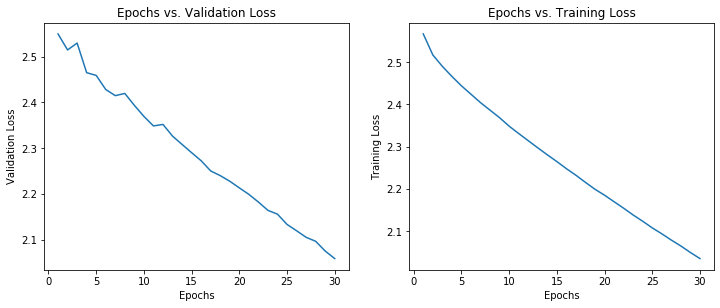

In [16]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,epochs+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,epochs+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

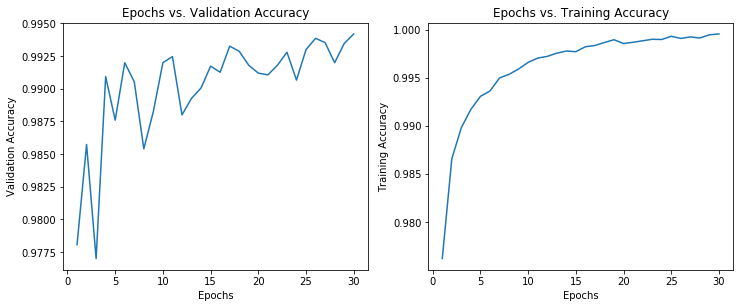

In [18]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,epochs+1), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,epochs+1), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [21]:
epochs = 30
predictions1, history1 = run_vgg16()

Train on 45000 samples, validate on 15000 samples
Epoch 1/30
45000/45000 [==============================] - 28s 616us/step - loss: 2.0213 - accuracy: 0.9994 - val_loss: 2.0479 - val_accuracy: 0.9936
Epoch 2/30
45000/45000 [==============================] - 28s 615us/step - loss: 2.0064 - accuracy: 0.9997 - val_loss: 2.0308 - val_accuracy: 0.9936
Epoch 3/30
45000/45000 [==============================] - 28s 614us/step - loss: 1.9926 - accuracy: 0.9997 - val_loss: 2.0204 - val_accuracy: 0.9935
Epoch 4/30
45000/45000 [==============================] - 28s 613us/step - loss: 1.9787 - accuracy: 0.9997 - val_loss: 2.0040 - val_accuracy: 0.9939
Epoch 5/30
45000/45000 [==============================] - 28s 615us/step - loss: 1.9650 - accuracy: 0.9997 - val_loss: 1.9903 - val_accuracy: 0.9941
Epoch 6/30
45000/45000 [==============================] - 28s 613us/step - loss: 1.9512 - accuracy: 0.9998 - val_loss: 1.9766 - val_accuracy: 0.9935
Epoch 7/30
45000/45000 [==============================] 

In [ ]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.28 %


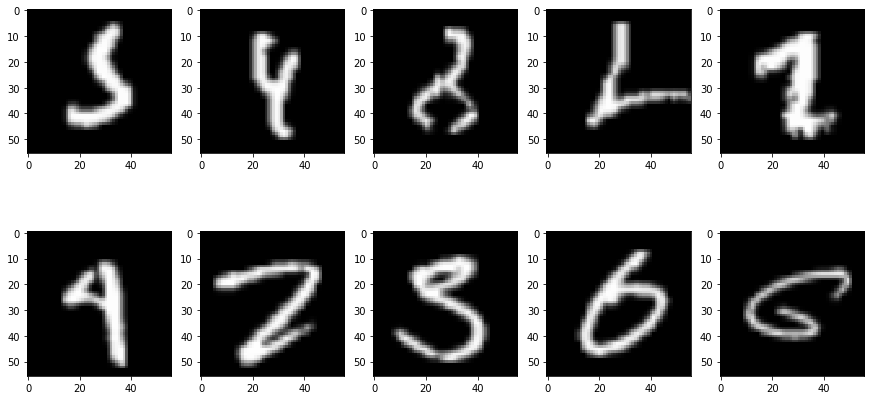

True:          [5 4 8 2 2]
classified as: [3 8 2 4 1]
True:          [4 2 3 6 6]
classified as: [9 7 5 0 5]


In [20]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_prepro[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_prepro[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))